## **Quantile Regression with CT + tabular features [pytorch]**

<p align="center">
  <img src="https://i0.wp.com/post.medicalnewstoday.com/wp-content/uploads/sites/3/2020/08/What-is-idiopathic-pulmonary-fibrosis_header-1024x575.jpg?w=1155&h=1528" />
</p>


### **What is IPF?**

Idiopathic pulmonary fibrosis (IPF) is a chronic and progressive lung condition. IPF causes scar tissue to build up in the lungs, leading to shortness of breath and a persistent cough.

Pulmonary fibrosis is a scarring of the lungs.

The NHLBI state that IPF occurs when the lung tissue that surrounds the air sacs thickens and becomes stiff, leading to permanent scarring of the lungs.

This scarring affects the function of the lungs, making it difficult to breathe.

- https://www.medicalnewstoday.com/articles/idiopathic-pulmonary-fibrosis#definition

### **What are we doing?**


In this competiton, we're given a CT scan (which contains different number of slices), multiple observation of patients' FVC with tabular features. We need to predict past and future FVC (Forced vital capacity) from that data.

### **How are we doing it?**


1. We're going to extract useful features from the CT scans (volume, histogram mean, skew, kurtosis).
2. We'll merge the CT features with tabular features.
3. We'll use quantile regression model to predict the three percentiles with quantile loss function that'll give us the FVC and confidence.


In [1]:
# necessary imports
import os
import cv2
import random
import pickle
import glob
from pathlib import Path
import gc
from tqdm.notebook import tqdm
import pandas as pd
import numpy as np
from PIL import Image
from tqdm.auto import tqdm

import pydicom
from pydicom.tag import Tag

import scipy.ndimage as ndimage
from scipy.ndimage import zoom
from scipy.stats import kurtosis
from scipy.stats import skew

from sklearn.cluster import KMeans

from skimage import measure, morphology, segmentation

### Everything we need to extract features from CT slices.

In [2]:
# aggregation of ct features and tabular data

def load_scan(path):
    """
    Loads scans from a folder and into a list.
    
    Parameters: path (Folder path)
    
    Returns: slices (List of slices)
    """
    slices = [pydicom.read_file(path + '/' + s) for s in os.listdir(path)]
    slices.sort(key = lambda x: int(x.InstanceNumber))
    
    try:
        slice_thickness = np.abs(slices[0].ImagePositionPatient[2] - slices[1].ImagePositionPatient[2])
    except:
        try:
            slice_thickness = np.abs(slices[0].SliceLocation - slices[1].SliceLocation)
        except:
            try:
                slice_thickness = slices[0].SliceThickness
            except:
                slice_thickness = 0.5 # random value for now
            
    # print(slice_thickness)
        
    for s in slices:
        s.SliceThickness = slice_thickness
        
    return slices

def transform_to_hu(slices):
    """
    transform dicom.pixel_array to Hounsfield.
    Parameters: list dicoms
    Returns:numpy Hounsfield
    """
    
    images = np.stack([file.pixel_array for file in slices])
    images = images.astype(np.int16)

    # convert ouside pixel-values to air:
    # I'm using <= -1000 to be sure that other defaults are captured as well
    images[images <= -1000] = 0
    
    # convert to HU
    for n in range(len(slices)):
        
        intercept = slices[n].RescaleIntercept
        slope = slices[n].RescaleSlope
        
        if slope != 1:
            images[n] = slope * images[n].astype(np.float64)
            images[n] = images[n].astype(np.int16)
            
        images[n] += np.int16(intercept)
    
    return np.array(images, dtype=np.int16)

def generate_internal_mask(image):
    """
    Generates markers for a given image.
    Parameters: image
    Returns: Internal Marker, External Marker, Watershed Marker
    """
    
    #Creation of the internal Marker
    marker_internal = image < -400
    marker_internal = segmentation.clear_border(marker_internal)
    marker_internal_labels = measure.label(marker_internal)
    
    areas = [r.area for r in measure.regionprops(marker_internal_labels)]
    areas.sort()
    
    if len(areas) > 2:
        for region in measure.regionprops(marker_internal_labels):
            if region.area < areas[-2]:
                for coordinates in region.coords:                
                       marker_internal_labels[coordinates[0], coordinates[1]] = 0
    
    marker_internal = marker_internal_labels > 0
    
    return marker_internal

def generate_markers(image):
    """
    Generates markers for a given image.
    Parameters: image
    Returns: Internal Marker, External Marker, Watershed Marker
    """
    
    #Creation of the internal Marker
    marker_internal = image < -400
    marker_internal = segmentation.clear_border(marker_internal)
    marker_internal_labels = measure.label(marker_internal)
    
    areas = [r.area for r in measure.regionprops(marker_internal_labels)]
    areas.sort()
    
    if len(areas) > 2:
        for region in measure.regionprops(marker_internal_labels):
            if region.area < areas[-2]:
                for coordinates in region.coords:                
                       marker_internal_labels[coordinates[0], coordinates[1]] = 0
    
    marker_internal = marker_internal_labels > 0
    
    # Creation of the External Marker
    external_a = ndimage.binary_dilation(marker_internal, iterations=10)
    external_b = ndimage.binary_dilation(marker_internal, iterations=55)
    marker_external = external_b ^ external_a
    
    # Creation of the Watershed Marker
    marker_watershed = np.zeros((image.shape[0], image.shape[1]), dtype=np.int)
    marker_watershed += marker_internal * 255
    marker_watershed += marker_external * 128
    
    return marker_internal, marker_external, marker_watershed

def seperate_lungs_Watershed(image, iterations = 1):
    """
    Segments lungs using various techniques.
    
    Parameters: image (Scan image), iterations (more iterations, more accurate mask)
    
    Returns: 
        - Segmented Lung
        - Lung Filter
        - Outline Lung
        - Watershed Lung
        - Sobel Gradient
    """
    
    marker_internal, marker_external, marker_watershed = generate_markers(image)
    
    
    '''
    Creation of Sobel Gradient
    '''
    
    # Sobel-Gradient
    sobel_filtered_dx = ndimage.sobel(image, 1)
    sobel_filtered_dy = ndimage.sobel(image, 0)
    sobel_gradient = np.hypot(sobel_filtered_dx, sobel_filtered_dy)
    sobel_gradient *= 255.0 / np.max(sobel_gradient)
    
    
    '''
    Using the watershed algorithm
    
    
    We pass the image convoluted by sobel operator and the watershed marker
    to morphology.watershed and get a matrix matrix labeled using the 
    watershed segmentation algorithm.
    '''
    watershed = morphology.watershed(sobel_gradient, marker_watershed)
    
    
    
    return watershed

def crop_image(img: np.ndarray):
    edge_pixel_value = img[0, 0]
    mask = img != edge_pixel_value
    return img[np.ix_(mask.any(1),mask.any(0))]

def resize_image(img: np.ndarray,reshape=(512,512)):
    img = [cv2.resize(im,(512,512)) for im in img]
    return img

def preprocess_img(img,local_pd):
    #if local_pd.resize_type == 'resize':
    #    img = [resize_image(im) for im in img]
    if local_pd.resize_type == 'crop':
        img = [crop_image(im) for im in img]
        
    return np.array(img, dtype=np.int16)

def func_volume(patient_scan,patient_mask):
    pixel_spacing = patient_scan.PixelSpacing
    slice_thickness = patient_scan.SliceThickness
    slice_volume = np.count_nonzero(patient_mask)*pixel_spacing[0]*pixel_spacing[1]*slice_thickness
    return slice_volume

def caculate_lung_volume(patient_scans,patient_images):
    """
    caculate volume of lung from mask
    Parameters: list dicom scans,list patient CT image
    Returns: volume cm³　(float)
    """
    # patient_masks = pool.map(generate_internal_mask,patient_images)
    patient_masks = list(map(generate_internal_mask,patient_images)) # non-parallel version
    lung_volume = np.array(list(map(func_volume,patient_scans,patient_masks))).sum()

    return lung_volume*0.001

def caculate_histgram_statistical(patient_images,thresh = [-500,-50]):
    """
    caculate hisgram kurthosis of lung hounsfield
    Parameters: list patient CT image 512*512,thresh divide lung
    Returns: histgram statistical characteristic(Mean,Skew,Kurthosis)
    """
    statistical_characteristic = dict(Mean=0,Skew=0,Kurthosis=0)
    num_slices = len(patient_images)
    patient_images = patient_images[int(num_slices*0.1):int(num_slices*0.9)]
    patient_images_mean = np.mean(patient_images,0)
    
    s_pixel = patient_images_mean.flatten()
    s_pixel = s_pixel[np.where((s_pixel)>thresh[0]&(s_pixel<thresh[1]))]
    
    statistical_characteristic['Mean'] = np.mean(s_pixel)
    statistical_characteristic['Skew'] = skew(s_pixel)
    statistical_characteristic['Kurthosis'] = kurtosis(s_pixel)
    
    return statistical_characteristic

def aggregate_dicom_features(dicom_path = 'data_download/train/', csv_path = 'data_download/train.csv', show = True): # pass path to datafolder
    
    Patients_id = os.listdir(dicom_path)

    n_dicom_dict = {"Patient":[],"n_dicom":[],"list_dicom":[]}

    for Patient_id in Patients_id:
        dicom_id_path = glob.glob(dicom_path + Patient_id + "/*")
        n_dicom_dict["n_dicom"].append(len(dicom_id_path))
        n_dicom_dict["Patient"].append(Patient_id)
        list_dicom_id = sorted([int(i.split("/")[-1][:-4]) for i in dicom_id_path])
        n_dicom_dict["list_dicom"].append(list_dicom_id)

    dicom_pd = pd.DataFrame(n_dicom_dict)
    
    if show:
        dicom_pd.head()
    
    dicom_pd['height'],dicom_pd['width'] = -1,-1
    for Patient_id in Patients_id:
        dicom_id_path = glob.glob(dicom_path + Patient_id + "/*")
        for patient_dicom_id_path in dicom_id_path:
            try:
                dicom = pydicom.dcmread(patient_dicom_id_path)
                dicom_pd.loc[dicom_pd.Patient==Patient_id,'height'] = dicom.Rows
                dicom_pd.loc[dicom_pd.Patient==Patient_id,'width'] = dicom.Columns
            except:
                dicom_pd.loc[dicom_pd.Patient==Patient_id,'height'] = 512
                dicom_pd.loc[dicom_pd.Patient==Patient_id,'width'] = 512
                
            
            
    reshape_dicom_pd = dicom_pd.loc[(dicom_pd.height!=512) | (dicom_pd.width!=512),:]
    reshape_dicom_pd = reshape_dicom_pd.reset_index(drop=True)
    
    if show:
        reshape_dicom_pd.head()
    
    crop_id = list(reshape_dicom_pd[reshape_dicom_pd['height']!=reshape_dicom_pd['width']]['Patient'])
    reshape_dicom_pd['resize_type'] = 'resize'
    reshape_dicom_pd.loc[reshape_dicom_pd.Patient.isin(crop_id),'resize_type'] = 'crop'
    
    dicom_pd['resize_type'] = 'no'
    for idx,i in enumerate(reshape_dicom_pd['Patient']):
        dicom_pd.loc[dicom_pd.Patient==i,'resize_type'] = reshape_dicom_pd.loc[idx,'resize_type']
    
    if show:
        dicom_pd.head()
    
    train_pd = pd.read_csv(csv_path)
    temp_pd = pd.DataFrame(columns=train_pd.columns)
    
    for i in range(len(dicom_pd)):
        patient_pd = train_pd[train_pd.Patient==dicom_pd.iloc[i].Patient]
        zeroweek = patient_pd['Weeks'].min()
        if sum(patient_pd.Weeks==zeroweek)>1:
            print(pd.unique(patient_pd.Patient))
        temp_pd = temp_pd.append(patient_pd[patient_pd.Weeks==zeroweek].iloc[0])
    dicom_pd = pd.merge(dicom_pd, temp_pd, on=['Patient'])
    dicom_pd.head()
    
    lung_stat_pd = pd.DataFrame(columns=['Patient','Volume','Mean','Skew','Kurthosis'])


    for i in tqdm(range(len(dicom_pd))):
        path = os.path.join(dicom_path,dicom_pd.iloc[i].Patient)
        lung_stat_pd.loc[i,'Patient'] = dicom_pd.iloc[i].Patient
        try:
            patient_scans = load_scan(path)
            patient_images = transform_to_hu(patient_scans)
            patient_images = preprocess_img(patient_images,dicom_pd.iloc[i])
            lung_stat_pd.loc[i,'Volume'] = caculate_lung_volume(patient_scans,patient_images)

            patient_images = resize_image(patient_images) if dicom_pd.iloc[i].resize_type=='resize' else patient_images

            statistical_characteristic = caculate_histgram_statistical(patient_images)
            lung_stat_pd.loc[i,'Mean'] = statistical_characteristic['Mean']
            lung_stat_pd.loc[i,'Skew'] = statistical_characteristic['Skew']
            lung_stat_pd.loc[i,'Kurthosis'] = statistical_characteristic['Kurthosis']
        except:
            # fill up with mean features
            lung_stat_pd.loc[i,'Volume'] = 3554.55 # training mean
            lung_stat_pd.loc[i,'Mean'] = 81.75 
            lung_stat_pd.loc[i,'Skew'] = 1.90
            lung_stat_pd.loc[i,'Kurthosis'] = 5.69
            
            

    
    dicom_feature = pd.merge(dicom_pd, lung_stat_pd, on=['Patient'])
    
    dicom_feature = dicom_feature.drop(['list_dicom', 'height','width','resize_type','n_dicom'], axis=1)
    
    dicom_feature.head()
    
    return dicom_feature

### Using pre-computed features as it's slow.

In [3]:
# change in inference
use_saved = True

folder_path = '../input/osic-pulmonary-fibrosis-progression'
dicom_path = f'{folder_path}/train/'
csv_path = f'{folder_path}/train.csv'

# dummy data == real data, when only tabular
train_csv = f'{folder_path}/train.csv'
model_data_path = "processed-features" # may be changed

train_data_tab = pd.read_csv(train_csv)

if not use_saved:
    merged_data = aggregate_dicom_features(dicom_path = dicom_path, csv_path = csv_path, show = True)
else:
    merged_data = pd.read_csv(f'../input/{model_data_path}/train_data_ct_tab.csv')

In [4]:
train_data_tab.head()

,Patient,Weeks,FVC,Percent,Age,Sex,SmokingStatus
0,ID00007637202177411956430,-4,2315,58.253649,79,Male,Ex-smoker
1,ID00007637202177411956430,5,2214,55.712129,79,Male,Ex-smoker
2,ID00007637202177411956430,7,2061,51.862104,79,Male,Ex-smoker
3,ID00007637202177411956430,9,2144,53.950679,79,Male,Ex-smoker
4,ID00007637202177411956430,11,2069,52.063412,79,Male,Ex-smoker


In [5]:
merged_data.head()

,Patient,Weeks,FVC,Percent,Age,Sex,SmokingStatus,Volume,Mean,Skew,Kurthosis
0,ID00129637202219868188000,0,2253,59.622102,71,Male,Never smoked,1897.641704,89.996730,1.791319,4.466360
1,ID00210637202257228694086,0,2846,80.541091,76,Male,Currently smokes,3116.308724,67.600804,1.716944,3.896037
2,ID00276637202271694539978,6,3107,87.147986,77,Male,Ex-smoker,3257.095616,129.749505,3.053977,10.481746
3,ID00099637202206203080121,44,2934,82.212508,68,Male,Ex-smoker,2785.391995,52.233109,1.846776,4.262916
4,ID00342637202287526592911,23,2390,67.851465,72,Male,Ex-smoker,2631.115723,105.402775,2.978317,12.661993


### Let's merge features from CT scans and tabular ones into a single dataframe.

In [6]:
# merging both
train_data_tab['Volume'] = merged_data['Volume'].mean()
train_data_tab['Mean'] = merged_data['Mean'].mean()
train_data_tab['Skew'] = merged_data['Skew'].mean()
train_data_tab['Kurthosis'] = merged_data['Kurthosis'].mean()

for i in range(len(train_data_tab)):
    pid = train_data_tab.iloc[i]['Patient']
    train_data_tab.at[i, 'Volume'] = merged_data[merged_data['Patient']==pid].iloc[0]['Volume']
    train_data_tab.at[i, 'Mean'] = merged_data[merged_data['Patient']==pid].iloc[0]['Mean']
    train_data_tab.at[i, 'Skew'] = merged_data[merged_data['Patient']==pid].iloc[0]['Skew']
    train_data_tab.at[i, 'Kurthosis'] = merged_data[merged_data['Patient']==pid].iloc[0]['Kurthosis']

In [7]:
train_data_tab.head()

,Patient,Weeks,FVC,Percent,Age,Sex,SmokingStatus,Volume,Mean,Skew,Kurthosis
0,ID00007637202177411956430,-4,2315,58.253649,79,Male,Ex-smoker,2847.19009,124.028553,1.482019,2.590889
1,ID00007637202177411956430,5,2214,55.712129,79,Male,Ex-smoker,2847.19009,124.028553,1.482019,2.590889
2,ID00007637202177411956430,7,2061,51.862104,79,Male,Ex-smoker,2847.19009,124.028553,1.482019,2.590889
3,ID00007637202177411956430,9,2144,53.950679,79,Male,Ex-smoker,2847.19009,124.028553,1.482019,2.590889
4,ID00007637202177411956430,11,2069,52.063412,79,Male,Ex-smoker,2847.19009,124.028553,1.482019,2.590889


### Adding baseline week into the feature to let the model know about the offset (in weeks).

In [8]:
#getting base week for patient
def get_baseline_week(data):
    df = data.copy()
    df['Weeks'] = df['Weeks'].astype(int)
    df['min_week'] = df.groupby('Patient')['Weeks'].transform('min')
    df['baseline_week'] = df['Weeks'] - df['min_week']
    return df

#getting FVC for base week and setting it as bas_FVC of patient
def get_base_FVC(data):
    df = data.copy()
    base = df.loc[df.Weeks == df.min_week][['Patient','FVC']].copy()
    base.columns = ['Patient','base_FVC']
    
    base['nb']=1
    base['nb'] = base.groupby('Patient')['nb'].transform('cumsum')
    
    base = base[base.nb==1]
    base.drop('nb',axis =1,inplace=True)
    df = df.merge(base,on="Patient",how='left')
    df.drop(['min_week'], axis = 1)
    return df

In [9]:
from sklearn.preprocessing import StandardScaler,LabelEncoder,OneHotEncoder,PowerTransformer
from sklearn.model_selection import train_test_split, cross_val_score,cross_validate, KFold
from sklearn.metrics import make_scorer
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline

### Now, it's time to load the test data, aggregate features.

In [10]:
# inference
folder_path = '../input/osic-pulmonary-fibrosis-progression'
dicom_path = f'{folder_path}/test/'
csv_path = f'{folder_path}/test.csv'
test_merged = aggregate_dicom_features(dicom_path = dicom_path, csv_path = csv_path, show = True)
test_data_tab = pd.read_csv(csv_path)

In [11]:
test_data_tab.head()

,Patient,Weeks,FVC,Percent,Age,Sex,SmokingStatus
0,ID00419637202311204720264,6,3020,70.186855,73,Male,Ex-smoker
1,ID00421637202311550012437,15,2739,82.045291,68,Male,Ex-smoker
2,ID00422637202311677017371,6,1930,76.672493,73,Male,Ex-smoker
3,ID00423637202312137826377,17,3294,79.258903,72,Male,Ex-smoker
4,ID00426637202313170790466,0,2925,71.824968,73,Male,Never smoked


In [12]:
# merging both
test_data_tab['Volume'] = test_merged['Volume'].mean()
test_data_tab['Mean'] = test_merged['Mean'].mean()
test_data_tab['Skew'] = test_merged['Skew'].mean()
test_data_tab['Kurthosis'] = test_merged['Kurthosis'].mean()

for i in range(len(test_data_tab)):
    pid = test_data_tab.iloc[i]['Patient']
    try:
        test_data_tab.at[i, 'Volume'] = test_merged[test_merged['Patient']==pid].iloc[0]['Volume']
        test_data_tab.at[i, 'Mean'] = test_merged[test_merged['Patient']==pid].iloc[0]['Mean']
        test_data_tab.at[i, 'Skew'] = test_merged[test_merged['Patient']==pid].iloc[0]['Skew']
        test_data_tab.at[i, 'Kurthosis'] = test_merged[test_merged['Patient']==pid].iloc[0]['Kurthosis']
    except:
        print('failed at here: 1')

In [13]:
test_data_tab.head()

,Patient,Weeks,FVC,Percent,Age,Sex,SmokingStatus,Volume,Mean,Skew,Kurthosis
0,ID00419637202311204720264,6,3020,70.186855,73,Male,Ex-smoker,5553.877354,93.169759,2.810130,15.489320
1,ID00421637202311550012437,15,2739,82.045291,68,Male,Ex-smoker,7933.976501,78.688667,1.861537,4.041202
2,ID00422637202311677017371,6,1930,76.672493,73,Male,Ex-smoker,2409.800829,85.603671,1.276419,0.999685
3,ID00423637202312137826377,17,3294,79.258903,72,Male,Ex-smoker,3290.185919,82.746274,3.692260,17.112597
4,ID00426637202313170790466,0,2925,71.824968,73,Male,Never smoked,3684.040076,81.215809,1.430486,1.530936


In [14]:
# alisaing
train_data = train_data_tab
test_data = test_data_tab

sample_csv = f'{folder_path}/sample_submission.csv'

train_data.drop_duplicates(keep=False,inplace=True,subset=['Patient','Weeks'])
train_data = get_baseline_week(train_data)
train_data = get_base_FVC(train_data)

sample = pd.read_csv(sample_csv)
sample.drop("FVC",axis=1,inplace=True)
sample[["Patient","Weeks"]] = sample["Patient_Week"].str.split("_",expand=True) 
sample = sample.merge(test_data.drop("Weeks",axis=1),on="Patient",how="left")

#we have to predict for all weeks 
sample["min_Weeks"] = np.nan
sample = get_baseline_week(sample)
sample = get_base_FVC(sample)

In [15]:
train_data.head()

,Patient,Weeks,FVC,Percent,Age,Sex,SmokingStatus,Volume,Mean,Skew,Kurthosis,min_week,baseline_week,base_FVC
0,ID00007637202177411956430,-4,2315,58.253649,79,Male,Ex-smoker,2847.19009,124.028553,1.482019,2.590889,-4,0,2315
1,ID00007637202177411956430,5,2214,55.712129,79,Male,Ex-smoker,2847.19009,124.028553,1.482019,2.590889,-4,9,2315
2,ID00007637202177411956430,7,2061,51.862104,79,Male,Ex-smoker,2847.19009,124.028553,1.482019,2.590889,-4,11,2315
3,ID00007637202177411956430,9,2144,53.950679,79,Male,Ex-smoker,2847.19009,124.028553,1.482019,2.590889,-4,13,2315
4,ID00007637202177411956430,11,2069,52.063412,79,Male,Ex-smoker,2847.19009,124.028553,1.482019,2.590889,-4,15,2315


In [16]:
train_columns = ['baseline_week','base_FVC','Percent','Age','Sex','SmokingStatus', 'Volume', 'Mean', 'Skew', 'Kurthosis'] # more features
train_label = ['FVC']
sub_columns = ['Patient_Week','FVC','Confidence']

train = train_data[train_columns]
test = sample[train_columns]

In [17]:
train.head()

,baseline_week,base_FVC,Percent,Age,Sex,SmokingStatus,Volume,Mean,Skew,Kurthosis
0,0,2315,58.253649,79,Male,Ex-smoker,2847.19009,124.028553,1.482019,2.590889
1,9,2315,55.712129,79,Male,Ex-smoker,2847.19009,124.028553,1.482019,2.590889
2,11,2315,51.862104,79,Male,Ex-smoker,2847.19009,124.028553,1.482019,2.590889
3,13,2315,53.950679,79,Male,Ex-smoker,2847.19009,124.028553,1.482019,2.590889
4,15,2315,52.063412,79,Male,Ex-smoker,2847.19009,124.028553,1.482019,2.590889


In [18]:
# pre-processing, need to improve this
transformer = ColumnTransformer([('s',StandardScaler(),[0,1,2,3,6,7,8,9]),('o',OneHotEncoder(),[4,5])])
target = train_data[train_label].values
train = transformer.fit_transform(train)
test = transformer.transform(test)

### Now, a simple pytorch model with quantile loss (+ a weighted version of the metric).

In [29]:
import torch
import torch.nn as nn
import torch.functional as F
import torch.optim as optim
from torch.utils.data import TensorDataset, DataLoader

class Model(nn.Module):
    def __init__(self,n):
        super(Model,self).__init__()
        self.layer1 = nn.Linear(n,128)
        self.relu1 = nn.ELU()
        self.layer2 = nn.Linear(128,128)
        self.relu2 = nn.ELU()
        #self.layer3 = nn.Linear(64,32)
        #self.relu3 = nn.LeakyReLU()
        
        self.out1 = nn.Linear(128,3) # 3 outputs
            
    def forward(self,xb):
        x1 = self.relu1(self.layer1(xb))
        x1 = self.relu2(self.layer2(x1))
        # x1 = self.relu3(self.layer3(x1))
        
        o1 = self.out1(x1)
        return o1 

### We'll be saving the best models with k-fold validation

In [30]:
best_metrics_so_far = [99999999]*10 # the smaller the better, at most 10 folds

def run():
    
    def score(outputs,target):
        confidence = outputs[:,2] - outputs[:,0] # output -> 0-> 20% percentile, 50% percentile, 80% percentile
        clip = torch.clamp(confidence,min=70)
        target=torch.reshape(target,outputs[:,1].shape)
        delta = torch.abs(outputs[:,1] - target)
        delta = torch.clamp(delta,max=1000)
        sqrt_2 = torch.sqrt(torch.tensor([2.])).to(device)
        metrics = (delta*sqrt_2/clip) + torch.log(clip*sqrt_2)
        return torch.mean(metrics)
    
    def qloss(outputs,target):
        qs = [0.2,0.5,0.8]
        qs = torch.tensor(qs,dtype=torch.float).to(device)
        e =  outputs - target
        e.to(device)
        v = torch.max(qs*e,(qs-1)*e)
        return torch.mean(v)

    
    def loss_fn(outputs,target,l):
        return l * qloss(outputs,target) + (1- l) * score(outputs,target)
        
    def train_loop(train_loader,model,loss_fn,device,optimizer,lr_scheduler=None):
        model.train()
        losses = list()
        metrics = list()
        for i, (inputs, labels) in enumerate(train_loader):
            inputs = inputs.to(device)
            labels = labels.to(device)
            
            optimizer.zero_grad()
            with torch.set_grad_enabled(True):           
                outputs = model(inputs)                 
                metric = score(outputs,labels)

                loss = loss_fn(outputs,labels,0.77)
                metrics.append(metric.cpu().detach().numpy())
                losses.append(loss.cpu().detach().numpy())

                loss.backward()

                optimizer.step()
                if lr_scheduler != None:
                    lr_scheduler.step()
            
        return losses,metrics
    
    def valid_loop(k,valid_loader,model,loss_fn,device):
        model.eval()
        losses = list()
        metrics = list()
        for i, (inputs, labels) in enumerate(valid_loader):
            inputs = inputs.to(device)
            labels = labels.to(device)
            
            outputs = model(inputs)                 
            metric = score(outputs,labels)
            
            loss = loss_fn(outputs,labels,0.77)
            metrics.append(metric.cpu().detach().numpy())
            losses.append(loss.cpu().detach().numpy())
        
        # print(np.mean(metrics))
        global best_metrics_so_far
        if np.mean(metrics) <= best_metrics_so_far[k]:
            torch.save(model.state_dict(),f'model{k}.bin')
            print('model saved')
            best_metrics_so_far[k] = np.mean(metrics)
            
        return losses,metrics    

    NFOLDS = 2
    kfold = KFold(NFOLDS,shuffle=True,random_state=1997)
    
    #kfold
    for k , (train_idx,valid_idx) in enumerate(kfold.split(train)):
        batch_size = 128
        epochs = 666
        device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
        print(f"{device} is used")
        x_train,x_valid,y_train,y_valid = train[train_idx,:],train[valid_idx,:],target[train_idx],target[valid_idx]
        n = x_train.shape[1]
        model = Model(n)
        model.to(device)
        lr = 0.2
        optimizer = optim.Adam(model.parameters(),lr=lr)
        lr_scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=25, gamma=0.44)

        train_tensor = torch.tensor(x_train,dtype=torch.float)
        y_train_tensor = torch.tensor(y_train,dtype=torch.float)

        train_ds = TensorDataset(train_tensor,y_train_tensor)
        train_dl = DataLoader(train_ds,
                             batch_size = batch_size,
                             num_workers=4,
                             shuffle=True
                             )

        valid_tensor = torch.tensor(x_valid,dtype=torch.float)
        y_valid_tensor = torch.tensor(y_valid,dtype=torch.float)

        valid_ds = TensorDataset(valid_tensor,y_valid_tensor)
        valid_dl = DataLoader(valid_ds,
                             batch_size = batch_size,
                             num_workers=4,
                             shuffle=False
                             )
        
        print(f"Fold {k}")
        for i in range(epochs):
            losses,metrics = train_loop(train_dl,model,loss_fn,device,optimizer,lr_scheduler)
            valid_losses,valid_metrics = valid_loop(k,valid_dl,model,loss_fn,device)
            if (i+1)%50==0:
                print(f"epoch:{i} Training | loss:{np.mean(losses)} score: {np.mean(metrics)}| \n Validation | loss:{np.mean(valid_losses)} score:{np.mean(valid_metrics)}|")
        

In [31]:
run()

cuda:0 is used
Fold 0
model saved
model saved
model saved
model saved
model saved
model saved
model saved
model saved
model saved
model saved
model saved
model saved
model saved
model saved
model saved
model saved
model saved
model saved
model saved
model saved
model saved
model saved
model saved
model saved
model saved
epoch:49 Training | loss:36.75594711303711 score: 6.817409992218018| 
 Validation | loss:37.654727935791016 score:6.86777925491333|
model saved
model saved
model saved
model saved
model saved
model saved
model saved
model saved
model saved
model saved
model saved
model saved
model saved
model saved
model saved
model saved
model saved
model saved
model saved
model saved
model saved
model saved
model saved
model saved
model saved
model saved
model saved
model saved
model saved
model saved
model saved
model saved
model saved
model saved
model saved
model saved
model saved
model saved
model saved
model saved
model saved
model saved
epoch:99 Training | loss:36.75171279907226

In [33]:
def inference(model_path = ''):
    device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
    nfold = 2
    all_prediction = np.zeros((test.shape[0],3))
    
    model_weights = [0.5, 0.5]
    for k in range(nfold):
        n = train.shape[1]
        
        model = Model(n)
        model.load_state_dict(torch.load(f"model{k}.bin"))
        predictions = list()
        model.to(device)
        test_tensor = torch.tensor(test,dtype=torch.float)
        test_dl = DataLoader(test_tensor,
                        batch_size=64,
                        num_workers=2,
                        shuffle=False)
    
        with torch.no_grad():
            for i, inputs in enumerate(test_dl):
                inputs = inputs.to(device, dtype=torch.float)
                outputs= model(inputs) 
                predictions.extend(outputs.cpu().detach().numpy())

        all_prediction += np.array(predictions) * model_weights[k]
        
    return all_prediction  

In [34]:
prediction = inference()
sample["Confidence"] = np.abs(prediction[:,2] - prediction[:,0])
sample["FVC"] = prediction[:,1]
sub = sample[sub_columns]

In [35]:
sub.head()

,Patient_Week,FVC,Confidence
0,ID00419637202311204720264_-12,2794.954590,199.253906
1,ID00421637202311550012437_-12,2957.765259,192.605225
2,ID00422637202311677017371_-12,2122.764160,149.279114
3,ID00423637202312137826377_-12,3101.973633,237.216675
4,ID00426637202313170790466_-12,2811.050293,189.033569


In [36]:
# plotting
import matplotlib.pyplot as plt
import numpy as np

def plot_prediction(pid = 'ID00419637202311204720264'):

    fvc = np.array(sub[sub['Patient_Week'].str.contains(pid)]['FVC'])
    conf = np.array(sub[sub['Patient_Week'].str.contains(pid)]['Confidence'])

    month = np.array(range(-12,134))

    fig, ax = plt.subplots()
    ax.plot(month,fvc)
    ax.fill_between(month, (fvc-conf/2), (fvc+conf/2), color='b', alpha=.1)
    ax.set_title(f'PID: {pid}')
    ax.set_xlabel('month')
    ax.set_ylabel('FVC')


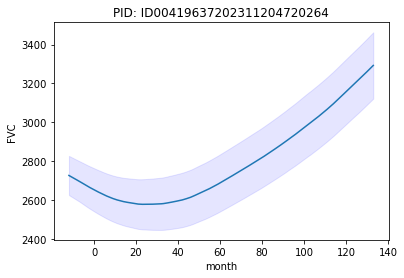

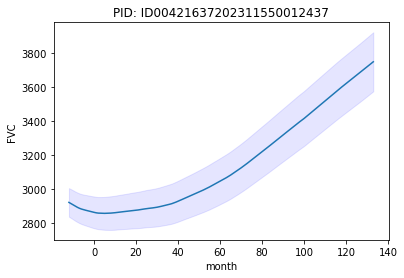

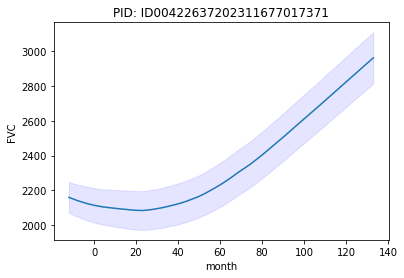

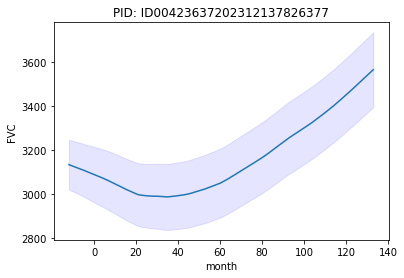

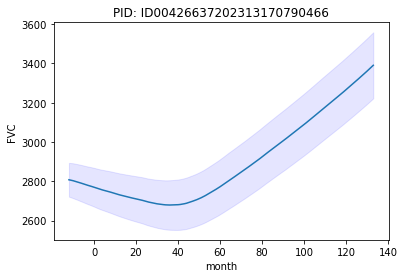

In [26]:
# let's see our predictions
pid_list = ['ID00419637202311204720264', 'ID00421637202311550012437', 'ID00422637202311677017371', 'ID00423637202312137826377', 'ID00426637202313170790466']

for pid in pid_list:
    plot_prediction(pid)

In [37]:
sub.to_csv("submission.csv",index=False)